In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
import torchvision
from torchsummary import summary
from torch.utils.data.sampler import SubsetRandomSampler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


#### Upload the given dataset first

In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import random
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines)


# print(len(all_categories))
print(all_categories)

['data/names/Greek.txt', 'data/names/Polish.txt', 'data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt']
57
Slusarski
{'Greek': ['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos', 'Anetakis', 'Angelopoulos', 'Antimisiaris', 'Antipas', 'Antonakos', 'Antoniadis', 'Antonopoulos', 'Antonopoulos', 'Antonopoulos', 'Arvanitoyannis', 'Avgerinos', 'Banos', 'Batsakis', 'Bekyros', 'Belesis', 'Bertsimas', 'Bilias', 'Blades', 'Bouloukos', 'Brisimitzakis', 'Bursinos', 'Calogerakis', 'Calpis', 'Chellos', 'Christakos', 'Christodoulou', 'Christou', 'Chrysanthopoulos', 'Chrysanthopoulos', 'Comino', 'Close', 'Close', 'Close', 'Close',

In [ ]:
for i in category_lines:
  print(len(category_lines[i]))

203
139
3668
2000
94
298
724
74
73
232
9408
277
297
519
709
991
268
100


In [ ]:
all_letters, all_categories

("abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'",
 ['Greek',
  'Polish',
  'English',
  'Arabic',
  'Korean',
  'Spanish',
  'German',
  'Portuguese',
  'Vietnamese',
  'Irish',
  'Russian',
  'French',
  'Dutch',
  'Czech',
  'Italian',
  'Japanese',
  'Chinese',
  'Scottish'])



* To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.
* To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.






In [ ]:
ll=[]
for key in category_lines:
  for i in range(len(category_lines[key])):
    ll.append([key,category_lines[key][i]])


In [ ]:
data=pd.DataFrame(ll)
data.columns=['class','name']
data

,class,name
0,Greek,Adamidis
1,Greek,Adamou
2,Greek,Agelakos
3,Greek,Akrivopoulos
4,Greek,Alexandropoulos
...,...,...
20069,Scottish,Mccallum
20070,Scottish,Whyte
20071,Scottish,Jackson
20072,Scottish,Mclaughlin


In [ ]:
X=data['name']
y=data['class']

In [ ]:
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y)

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X_tv,y_tv,test_size=0.11111,random_state=42,stratify=y_tv)

In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryToTensor(category):
  return torch.tensor([all_categories.index(category)], dtype=torch.long)


print(letterToTensor('J'))


# print(lineToTensor('Jones'))
print(lineToTensor('Jones').size())


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# Architecture-1

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)



In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)

    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [ ]:
criterion = nn.NLLLoss()

In [1]:
def train(category_tensor, line_tensor,model,optimizer):
    hidden = model.initHidden()
    line_tensor = line_tensor.cuda()
    hidden = hidden.cuda()
    model.zero_grad()
    


    for i in range(line_tensor.size()[0]):

        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def eval(category_tensor, line_tensor,model):
  hidden = model.initHidden()
  hidden = hidden.cuda()
  line_tensor =line_tensor.cuda()
  for i in range(line_tensor.size()[0]):
      output, hidden = model(line_tensor[i], hidden)
  loss = criterion(output, category_tensor.cuda())
  return output, loss.item()
  


In [ ]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

print_every = 500

def evaluate_model(epochs,model,optimiser):
  train_losses = []
  val_losses=[]
  for k in range(epochs):
    train_loss = 0
    val_loss=0
    for iter in range(len(X_train)):
      category=y_train.iloc[iter]
      line=X_train.iloc[iter]
      category_tensor=categoryToTensor(category)
      line_tensor=lineToTensor(line)

      output,loss=train(category_tensor, line_tensor,model,optimiser)
      train_loss += loss

      # Print iter number, loss, name and guess
      # if iter % 2000 == 0:
      #     guess, guess_i = categoryFromOutput(output)
      #     correct = '✓' if guess == category else '✗ (%s)' % category
      #     print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / len(X_train) * 100, timeSince(start), loss, line, guess, correct))


    print(f"Epoch {k+1} Train Loss :",train_loss /len(X_train))
    train_losses.append(train_loss /len(X_train) )
    train_loss = 0


    Preds=[]
    for iter in range(len(X_val)):
      category=y_val.iloc[iter]
      line=X_val.iloc[iter]
      category_tensor=categoryToTensor(category)
      line_tensor=lineToTensor(line)

      output,loss=eval(category_tensor, line_tensor,model)

      val_loss +=loss

      p,p_index=categoryFromOutput(output)

      Preds.append(p)
      # if iter % print_every == 0:
      #     guess, guess_i = categoryFromOutput(output)
      #     correct = '✓' if guess == category else '✗ (%s)' % category
      #     print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / len(X_val) * 100, timeSince(start), loss, line, guess, correct))
      
    print(f"============= Epoch {k+1} Val Loss :",val_loss /len(X_val))
    val_losses.append(val_loss /len(X_val) )
    val_loss = 0

  return train_losses,val_losses,Preds

  

Model 1  (SGD optimiser)

In [ ]:
n_hidden1 = 128
rnn1 = RNN(n_letters, n_hidden1, n_categories).cuda()
learning_rate = 0.001
optimizer1 = torch.optim.SGD(rnn1.parameters(),lr= learning_rate)


In [ ]:
trL1,vL1,preds1=evaluate_model(20,rnn1,optimizer1)

Epoch 1 Train Loss : 1.7136896492053613
============= Epoch 1 Val Loss : 1.5296980438761383
Epoch 2 Train Loss : 1.4429066058558662
============= Epoch 2 Val Loss : 1.3603924065559316
Epoch 3 Train Loss : 1.2961565404305624
============= Epoch 3 Val Loss : 1.2375256373295171
Epoch 4 Train Loss : 1.2055033391248542
============= Epoch 4 Val Loss : 1.1690797498419536
Epoch 5 Train Loss : 1.1483648477070068
============= Epoch 5 Val Loss : 1.125729176960584
Epoch 6 Train Loss : 1.1063900415497014
============= Epoch 6 Val Loss : 1.094658942095575
Epoch 7 Train Loss : 1.0723073016364346
============= Epoch 7 Val Loss : 1.0696680104778917
Epoch 8 Train Loss : 1.0427124730706034
============= Epoch 8 Val Loss : 1.0469551489262507
Epoch 9 Train Loss : 1.0165440458194086
============= Epoch 9 Val Loss : 1.025400531934336
Epoch 10 Train Loss : 0.9934463268326447
============= Epoch 10 Val Loss : 1.0052986076036352
Epoch 11 Train Loss : 0.9730348961127978
============= Epoch 11 Val Loss : 0.9868

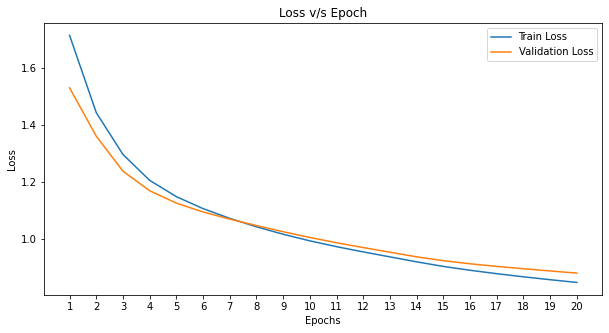

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL1)
plt.plot(epochArr,vL1)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss","Validation Loss"])

Model 2 (Adam optimiser)

In [ ]:
n_hidden1 = 128
rnn2 = RNN(n_letters, n_hidden1, n_categories).cuda()
learning_rate = 0.001
optimizer2 = torch.optim.Adam(rnn2.parameters(),lr= learning_rate)

In [ ]:
trL2,vL2,preds2=evaluate_model(20,rnn2,optimizer2)

Epoch 1 Train Loss : 1.1897038032388703
============= Epoch 1 Val Loss : 0.996488901734183
Epoch 2 Train Loss : 0.9402249852800079
============= Epoch 2 Val Loss : 0.9204598666717031
Epoch 3 Train Loss : 0.8839543913300186
============= Epoch 3 Val Loss : 0.9021395868784255
Epoch 4 Train Loss : 0.8537799862796331
============= Epoch 4 Val Loss : 0.8717451399039469
Epoch 5 Train Loss : 0.8381168325058707
============= Epoch 5 Val Loss : 0.8511684630899717
Epoch 6 Train Loss : 0.826559218482236
============= Epoch 6 Val Loss : 0.8606796655169014
Epoch 7 Train Loss : 0.8185204311960087
============= Epoch 7 Val Loss : 0.8585393581065989
Epoch 8 Train Loss : 0.8115161620996713
============= Epoch 8 Val Loss : 0.8564956104276129
Epoch 9 Train Loss : 0.8072527327966975
============= Epoch 9 Val Loss : 0.8574928116947511
Epoch 10 Train Loss : 0.8038956580186243
============= Epoch 10 Val Loss : 0.8268333719842
Epoch 11 Train Loss : 0.8001713687207167
============= Epoch 11 Val Loss : 0.842750

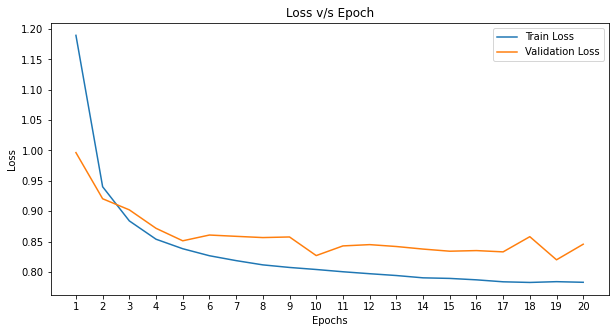

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL2)
plt.plot(epochArr,vL2)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss","Validation Loss"])

Beacuse Adam performed better. We'll now go with Adam \\
Now changing n_hidden

Model 3

In [ ]:
n_hidden2 = 64
rnn3 = RNN(n_letters, n_hidden2, n_categories).cuda()
learning_rate = 0.001
optimizer3 = torch.optim.Adam(rnn3.parameters(),lr= learning_rate)

In [ ]:
trL3,vL3,preds3=evaluate_model(20,rnn3,optimizer3)

Epoch 1 Train Loss : 1.1626196272105616
============= Epoch 1 Val Loss : 0.9409980468095832
Epoch 2 Train Loss : 0.900326143114135
============= Epoch 2 Val Loss : 0.8872493682649512
Epoch 3 Train Loss : 0.8459070824971938
============= Epoch 3 Val Loss : 0.86308136466012
Epoch 4 Train Loss : 0.8215544969280354
============= Epoch 4 Val Loss : 0.8477430282035536
Epoch 5 Train Loss : 0.8074986962358068
============= Epoch 5 Val Loss : 0.8344604101938444
Epoch 6 Train Loss : 0.7989984955365687
============= Epoch 6 Val Loss : 0.8293469935228135
Epoch 7 Train Loss : 0.7926459613297157
============= Epoch 7 Val Loss : 0.8273618880336536
Epoch 8 Train Loss : 0.7870096758621148
============= Epoch 8 Val Loss : 0.8289794440059177
Epoch 9 Train Loss : 0.7825274875405541
============= Epoch 9 Val Loss : 0.8308053117492634
Epoch 10 Train Loss : 0.7786827526456669
============= Epoch 10 Val Loss : 0.831222531002582
Epoch 11 Train Loss : 0.775868977731973
============= Epoch 11 Val Loss : 0.831351

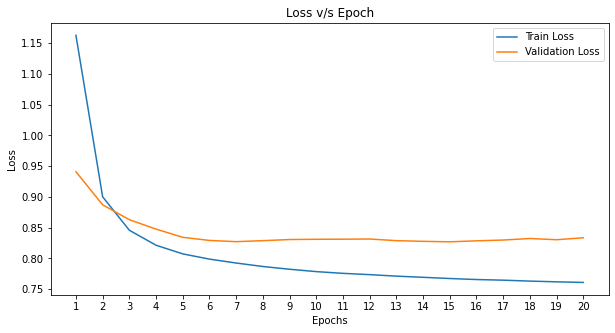

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL3)
plt.plot(epochArr,vL3)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss","Validation Loss"])

Beacuse n_hidden=128  performed better. We'll go with it.\
Now changing learning rate

Model 4

In [ ]:
n_hidden2 = 128
rnn4 = RNN(n_letters, n_hidden2, n_categories).cuda()
learning_rate2 = 0.0001
optimizer4 = torch.optim.Adam(rnn4.parameters(),lr= learning_rate2)

In [ ]:
trL4,vL4,preds4=evaluate_model(20,rnn4,optimizer4)

Epoch 1 Train Loss : 1.5295222367756462
============= Epoch 1 Val Loss : 1.3126848781129123
Epoch 2 Train Loss : 1.1994586676465129
============= Epoch 2 Val Loss : 1.1192259743642845
Epoch 3 Train Loss : 1.0693857422775113
============= Epoch 3 Val Loss : 1.0282197572972316
Epoch 4 Train Loss : 0.9871361335369659
============= Epoch 4 Val Loss : 0.9665294036121089
Epoch 5 Train Loss : 0.925613347164982
============= Epoch 5 Val Loss : 0.9147820846539283
Epoch 6 Train Loss : 0.8764047731243987
============= Epoch 6 Val Loss : 0.8734332293755566
Epoch 7 Train Loss : 0.8397520662144522
============= Epoch 7 Val Loss : 0.8482973096260142
Epoch 8 Train Loss : 0.8131818967434598
============= Epoch 8 Val Loss : 0.8319585896689273
Epoch 9 Train Loss : 0.7926368849466181
============= Epoch 9 Val Loss : 0.819889156189736
Epoch 10 Train Loss : 0.7761529708210917
============= Epoch 10 Val Loss : 0.8097219809674171
Epoch 11 Train Loss : 0.7624506047188464
============= Epoch 11 Val Loss : 0.801

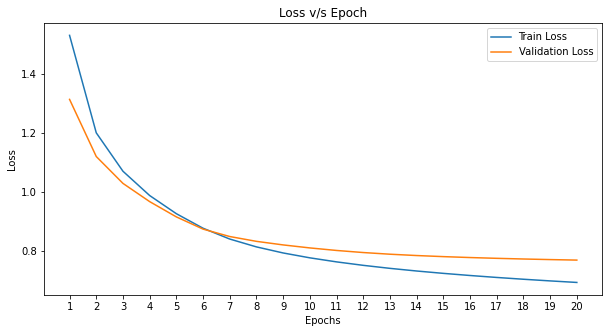

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL4)
plt.plot(epochArr,vL4)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss","Validation Loss"])

Out of all, we found that model 4 is best. So we will go further with it only and test it.

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(y_val)
print(preds4)

2990      English
15565     Russian
12404     Russian
10722     Russian
16433     Russian
           ...   
3669      English
7947      Russian
18803    Japanese
1428      English
51          Greek
Name: class, Length: 2008, dtype: object
['English', 'Russian', 'Russian', 'English', 'Russian', 'Arabic', 'Russian', 'Japanese', 'Czech', 'English', 'Japanese', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'English', 'Russian', 'Arabic', 'Arabic', 'Russian', 'Russian', 'Russian', 'Russian', 'Arabic', 'English', 'Russian', 'Czech', 'Russian', 'Russian', 'Arabic', 'Russian', 'English', 'Russian', 'Russian', 'Arabic', 'Russian', 'Russian', 'English', 'Italian', 'Russian', 'Russian', 'Dutch', 'English', 'French', 'English', 'Spanish', 'Russian', 'Arabic', 'Italian', 'Italian', 'Japanese', 'Russian', 'English', 'Czech', 'Arabic', 'Russian', 'English', 'Italian', 'Russian', 'Greek', 'Russian', 'English', 'English', 'Russian', 'Arabic', 'Japanese', 'Arabic', 'Russian', 'Arabic', 'Russian

In [ ]:
cm = confusion_matrix(y_val, preds4)
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,183,0,0,0,5,0,0,0,0,0,9,0,0,0,3,0,0,0
1,0,15,0,0,7,0,0,0,0,1,1,0,1,0,2,0,0,0
2,3,0,19,0,6,0,4,0,0,1,4,0,0,0,15,0,0,0
3,0,1,4,6,10,0,1,1,0,0,1,0,0,0,6,0,0,0
4,11,0,8,1,283,5,5,0,3,6,2,0,0,0,43,0,0,0
5,3,0,0,0,14,3,0,1,0,1,0,0,0,0,6,0,0,0
6,3,0,2,0,36,0,18,0,0,1,0,0,0,0,12,0,0,0
7,1,0,0,0,0,0,0,16,0,0,0,0,0,0,3,0,0,0
8,2,0,0,0,11,0,0,0,8,0,0,0,0,0,2,0,0,0
9,2,0,2,0,3,0,0,0,0,55,5,0,0,0,3,0,1,0


In [ ]:
def test_model(model):
    Preds=[]
    for iter in range(len(X_test)):
      category=y_test.iloc[iter]
      line=X_test.iloc[iter]
      category_tensor=categoryToTensor(category)
      line_tensor=lineToTensor(line)

      output,_=eval(category_tensor, line_tensor,model)
      p,p_index=categoryFromOutput(output)

      Preds.append(p)
    acc=(y_test==Preds).sum()/len(X_test)

    print("Test Accuracy : ",acc*100)

In [ ]:
test_model(rnn4)

Test Accuracy :  76.89243027888446


# Architecture -2

In [ ]:

class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Sequential(nn.Linear(input_size + hidden_size, int(hidden_size*2)),
                                 nn.ReLU(),
                                 nn.Linear(int(hidden_size*2),hidden_size),
                                 nn.ReLU(),
                                 nn.Linear(hidden_size,int(hidden_size/2)),
                                 nn.ReLU(),
                                 nn.Linear(int(hidden_size/2),hidden_size)
                                 )
        
        self.i2o = nn.Sequential(nn.Linear(input_size + hidden_size, int(output_size*2)),
                                 nn.ReLU(),
                                 nn.Linear(int(output_size*2),output_size),
                                 nn.ReLU(),
                                 nn.Linear(output_size,int(output_size/2)),
                                 nn.ReLU(),
                                 nn.Linear(int(output_size/2),output_size)
                                 )
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In this architecture we are only checking for Adam.

Model 1

In [ ]:
n_hidden1 = 128
rnn2_1 = RNN2(n_letters, n_hidden1, n_categories).cuda()
learning_rate = 0.001
optimizer2_1 = torch.optim.Adam(rnn2_1.parameters(),lr= learning_rate)

In [ ]:
trL2_1,vL2_1,preds2_1=evaluate_model(20,rnn2_1,optimizer2_1)

Epoch 1 Train Loss : 1.4517381144673895
============= Epoch 1 Val Loss : 1.2443089036935335
Epoch 2 Train Loss : 1.190542510555016
============= Epoch 2 Val Loss : 1.1409042561625946
Epoch 3 Train Loss : 1.1069717644007742
============= Epoch 3 Val Loss : 1.07446447787228
Epoch 4 Train Loss : 1.0652805255465956
============= Epoch 4 Val Loss : 1.073807078581478
Epoch 5 Train Loss : 1.0489469756094536
============= Epoch 5 Val Loss : 1.039465741063303
Epoch 6 Train Loss : 1.0349869782496892
============= Epoch 6 Val Loss : 1.0432045951880986
Epoch 7 Train Loss : 1.021130347164485
============= Epoch 7 Val Loss : 1.1241021771498285
Epoch 8 Train Loss : 1.008313159843521
============= Epoch 8 Val Loss : 1.007225561999161
Epoch 9 Train Loss : 1.0040233045539684
============= Epoch 9 Val Loss : 0.9860705949610359
Epoch 10 Train Loss : 1.002414411008052
============= Epoch 10 Val Loss : 0.9933202518588408
Epoch 11 Train Loss : 0.9909344809570596
============= Epoch 11 Val Loss : 0.9868370557

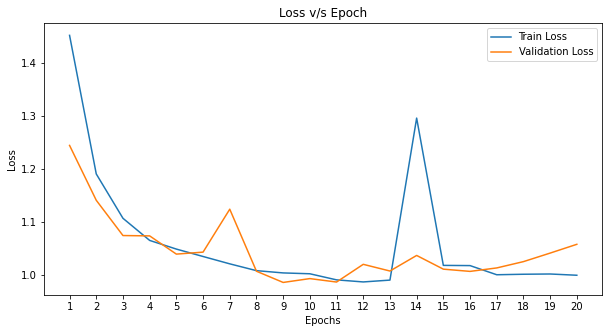

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL2_1)
plt.plot(epochArr,vL2_1)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss","Validation Loss"])

Model 2

In [ ]:
n_hidden2 = 64
rnn2_2 = RNN2(n_letters, n_hidden2, n_categories).cuda()
learning_rate = 0.0001
optimizer2_2 = torch.optim.Adam(rnn2_2.parameters(),lr= learning_rate)

In [ ]:
trL2_2,vL2_2,preds2_2=evaluate_model(20,rnn2_2,optimizer2_2)

Epoch 1 Train Loss : 1.8801957657541413
============= Epoch 1 Val Loss : 1.6764168614647779
Epoch 2 Train Loss : 1.608464430896825
============= Epoch 2 Val Loss : 1.5271879181481964
Epoch 3 Train Loss : 1.46751492436684
============= Epoch 3 Val Loss : 1.4272214862936974
Epoch 4 Train Loss : 1.3896349031534483
============= Epoch 4 Val Loss : 1.3668578281503254
Epoch 5 Train Loss : 1.3125947580517483
============= Epoch 5 Val Loss : 1.2681572972055384
Epoch 6 Train Loss : 1.233353388706943
============= Epoch 6 Val Loss : 1.214505092877487
Epoch 7 Train Loss : 1.1889297879559577
============= Epoch 7 Val Loss : 1.1889549926769478
Epoch 8 Train Loss : 1.1543892041145294
============= Epoch 8 Val Loss : 1.1517074275322685
Epoch 9 Train Loss : 1.12234602132197
============= Epoch 9 Val Loss : 1.109350048307035
Epoch 10 Train Loss : 1.08758843131752
============= Epoch 10 Val Loss : 1.0726229156605975
Epoch 11 Train Loss : 1.0501690525307823
============= Epoch 11 Val Loss : 1.04012837969

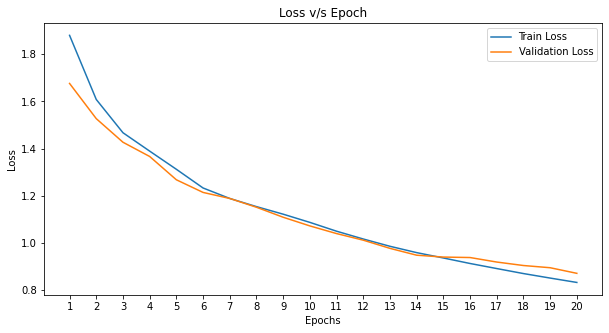

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL2_2)
plt.plot(epochArr,vL2_2)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss","Validation Loss"])



Model 3

In [ ]:
n_hidden1=128
rnn2_3 = RNN2(n_letters, n_hidden1, n_categories).cuda()
learning_rate = 0.0001
optimizer2_3 = torch.optim.Adam(rnn2_3.parameters(),lr= learning_rate)

In [ ]:
trL2_3,vL2_3,preds2_3=evaluate_model(20,rnn2_3,optimizer2_3)

Epoch 1 Train Loss : 1.8276986091171972
============= Epoch 1 Val Loss : 1.5907783037704597
Epoch 2 Train Loss : 1.4850949461081526
============= Epoch 2 Val Loss : 1.3982813997705286
Epoch 3 Train Loss : 1.3768939144754984
============= Epoch 3 Val Loss : 1.3224873578539005
Epoch 4 Train Loss : 1.2787706850845402
============= Epoch 4 Val Loss : 1.241782232936141
Epoch 5 Train Loss : 1.2098871612652948
============= Epoch 5 Val Loss : 1.1815649893170381
Epoch 6 Train Loss : 1.1504234778562143
============= Epoch 6 Val Loss : 1.1282593223245159
Epoch 7 Train Loss : 1.0912536019807642
============= Epoch 7 Val Loss : 1.077754560848161
Epoch 8 Train Loss : 1.048368346546511
============= Epoch 8 Val Loss : 1.039220403361808
Epoch 9 Train Loss : 1.008501238292523
============= Epoch 9 Val Loss : 1.0143446218143282
Epoch 10 Train Loss : 0.9751604363068072
============= Epoch 10 Val Loss : 0.9796627214931223
Epoch 11 Train Loss : 0.9424616930482623
============= Epoch 11 Val Loss : 0.950000

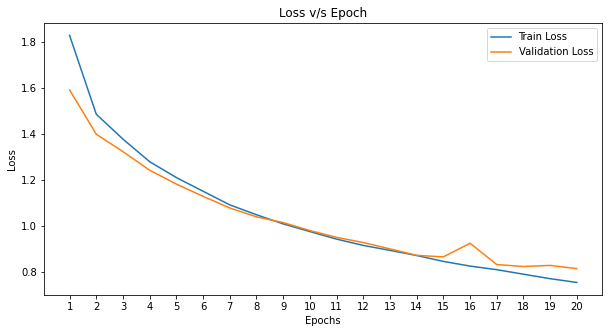

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL2_3)
plt.plot(epochArr,vL2_3)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss","Validation Loss"])

Out of all, we found that model 3 is best. So we will go further with it only and test it.

Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print(y_val)
print(preds2_3)

2990      English
15565     Russian
12404     Russian
10722     Russian
16433     Russian
           ...   
3669      English
7947      Russian
18803    Japanese
1428      English
51          Greek
Name: class, Length: 2008, dtype: object
['English', 'Russian', 'Russian', 'English', 'Russian', 'Arabic', 'Russian', 'Italian', 'Italian', 'English', 'Japanese', 'Russian', 'Japanese', 'Russian', 'Russian', 'Russian', 'English', 'Russian', 'Arabic', 'Greek', 'Russian', 'Russian', 'Russian', 'Russian', 'Arabic', 'Japanese', 'Russian', 'Arabic', 'Russian', 'Russian', 'Arabic', 'Russian', 'Greek', 'Russian', 'Russian', 'Arabic', 'Japanese', 'Russian', 'English', 'Japanese', 'English', 'Russian', 'English', 'English', 'English', 'English', 'Japanese', 'Russian', 'Arabic', 'Japanese', 'Russian', 'Japanese', 'Russian', 'English', 'Russian', 'Arabic', 'Russian', 'English', 'Italian', 'Russian', 'English', 'Russian', 'English', 'English', 'English', 'Arabic', 'Italian', 'Arabic', 'Russian', 'Arabic

In [ ]:
cm = confusion_matrix(y_val, preds2_3)
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,194,0,0,0,3,0,0,0,0,0,3,0,0,0,0,0,0,0
1,6,7,0,0,10,0,0,0,0,0,3,0,0,0,1,0,0,0
2,2,0,0,0,12,0,0,1,0,2,4,0,0,0,31,0,0,0
3,1,0,0,0,21,0,0,1,0,1,1,0,0,0,5,0,0,0
4,10,2,0,0,322,0,0,3,0,2,3,0,0,0,25,0,0,0
5,0,1,0,0,23,0,0,1,0,0,1,0,0,0,2,0,0,0
6,0,0,0,0,59,0,0,0,0,1,2,0,0,0,10,0,0,0
7,1,0,0,0,4,0,0,13,0,0,1,0,0,0,1,0,0,0
8,0,3,0,0,17,0,0,1,0,0,0,0,0,0,2,0,0,0
9,1,0,0,0,6,0,0,0,0,46,13,0,0,0,5,0,0,0


In [ ]:
def test_model(model):
    Preds=[]
    for iter in range(len(X_test)):
      category=y_test.iloc[iter]
      line=X_test.iloc[iter]
      category_tensor=categoryToTensor(category)
      line_tensor=lineToTensor(line)

      output,_=eval(category_tensor, line_tensor,model)
      p,p_index=categoryFromOutput(output)

      Preds.append(p)
    acc=(y_test==Preds).sum()/len(X_test)

    print("Test Accuracy : ",acc*100)

In [ ]:
test_model(rnn2_3)

Test Accuracy :  76.59362549800797


# Stacked RNN

In [ ]:
class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, output_size):
        super(RNN3, self).__init__()

        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2

        self.i2h = nn.Linear(input_size + hidden_size1, hidden_size1)
        self.i2o = nn.Linear(input_size + hidden_size1, 35)
        self.softmax = nn.LogSoftmax(dim=1)

        self.i2h2=nn.Linear(35+hidden_size2, hidden_size2)
        self.i2o2=nn.Linear(35+hidden_size2, output_size)

    def forward(self, input, hidden1,hidden2):
        combined = torch.cat((input, hidden1), 1)
        hidden1 = self.i2h(combined)
        output1 = self.i2o(combined)
        output1 = self.softmax(output1)

        combined2 = torch.cat((output1, hidden2), 1)
        hidden2 = self.i2h2(combined2)
        output = self.i2o2(combined2)
        output = self.softmax(output)

        return output, hidden1,hidden2

    def initHidden1(self):
        return torch.zeros(1, self.hidden_size1)
    def initHidden2(self):
        return torch.zeros(1, self.hidden_size2)

In [ ]:
def train2(category_tensor, line_tensor,model,optimizer):

    hidden1 = model.initHidden1()
    line_tensor = line_tensor.cuda()
    hidden1 = hidden1.cuda()

    hidden2 = model.initHidden2()
    hidden2 = hidden2.cuda()

    model.zero_grad()
    
    for i in range(line_tensor.size()[0]):

        output, hidden1,hidden2 = model(line_tensor[i], hidden1,hidden2)

    loss = criterion(output, category_tensor.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    # for p in rnn.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def eval2(category_tensor, line_tensor,model):
  hidden1 = model.initHidden1()
  hidden1 = hidden1.cuda()

  hidden2 = model.initHidden2()
  hidden2 = hidden2.cuda()

  line_tensor =line_tensor.cuda()
  for i in range(line_tensor.size()[0]):
      output, hidden1,hidden2 = model(line_tensor[i], hidden1,hidden2)
      
  loss = criterion(output, category_tensor.cuda())
  return output, loss.item()

In [ ]:

start = time.time()

print_every = 500

def evaluate_model2(epochs,model,optimiser):
  train_losses = []
  val_losses=[]
  for k in range(epochs):
    train_loss = 0
    val_loss=0
    for iter in range(len(X_train)):
      category=y_train.iloc[iter]
      line=X_train.iloc[iter]
      category_tensor=categoryToTensor(category)
      line_tensor=lineToTensor(line)

      output,loss=train2(category_tensor, line_tensor,model,optimiser)
      train_loss += loss

      # Print iter number, loss, name and guess
      # if iter % 2000 == 0:
      #     guess, guess_i = categoryFromOutput(output)
      #     correct = '✓' if guess == category else '✗ (%s)' % category
      #     print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / len(X_train) * 100, timeSince(start), loss, line, guess, correct))


    print(f"Epoch {k+1} Train Loss :",train_loss /len(X_train))
    train_losses.append(train_loss /len(X_train) )
    train_loss = 0


    Preds=[]
    for iter in range(len(X_val)):
      category=y_val.iloc[iter]
      line=X_val.iloc[iter]
      category_tensor=categoryToTensor(category)
      line_tensor=lineToTensor(line)

      output,loss=eval2(category_tensor, line_tensor,model)

      val_loss +=loss

      p,p_index=categoryFromOutput(output)

      Preds.append(p)
      # if iter % print_every == 0:
      #     guess, guess_i = categoryFromOutput(output)
      #     correct = '✓' if guess == category else '✗ (%s)' % category
      #     print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / len(X_val) * 100, timeSince(start), loss, line, guess, correct))
      
    print(f"============= Epoch {k+1} Val Loss :",val_loss /len(X_val))
    val_losses.append(val_loss /len(X_val) )
    val_loss = 0

  return train_losses,val_losses,Preds

  

In this architecture, we are only checking for SGD

Model 1

In [ ]:
n_hidden1 = 128
n_hidden2=64

rnn3_1 = RNN3(n_letters, n_hidden1, n_hidden2, n_categories).cuda()
learning_rate = 0.001
optimizer3_1 = torch.optim.SGD(rnn3_1.parameters(),lr= learning_rate)

In [ ]:
rnn3_1

RNN3(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=35, bias=True)
  (softmax): LogSoftmax(dim=1)
  (i2h2): Linear(in_features=99, out_features=64, bias=True)
  (i2o2): Linear(in_features=99, out_features=18, bias=True)
)

In [ ]:
trL3_1,vL3_1,preds3_1=evaluate_model2(20,rnn3_1,optimizer3_1)

Epoch 1 Train Loss : 1.811030725717451
============= Epoch 1 Val Loss : 1.8179969635024014
Epoch 2 Train Loss : 1.5832124495583202
============= Epoch 2 Val Loss : 1.6355508130064154
Epoch 3 Train Loss : 1.431011633920369
============= Epoch 3 Val Loss : 1.5214498508015446
Epoch 4 Train Loss : 1.2971443742013067
============= Epoch 4 Val Loss : 1.4261092622694258
Epoch 5 Train Loss : 1.1922669300753905
============= Epoch 5 Val Loss : 1.3464583788719389
Epoch 6 Train Loss : 1.1257457061730953
============= Epoch 6 Val Loss : 1.2944896414614688
Epoch 7 Train Loss : 1.0873692224548266
============= Epoch 7 Val Loss : 1.2599002172041673
Epoch 8 Train Loss : 1.059473984093259
============= Epoch 8 Val Loss : 1.2344238858913523
Epoch 9 Train Loss : 1.036033358641699
============= Epoch 9 Val Loss : 1.2128144329283777
Epoch 10 Train Loss : 1.0150572414265446
============= Epoch 10 Val Loss : 1.1922774853789317
Epoch 11 Train Loss : 0.9957253720374561
============= Epoch 11 Val Loss : 1.17237

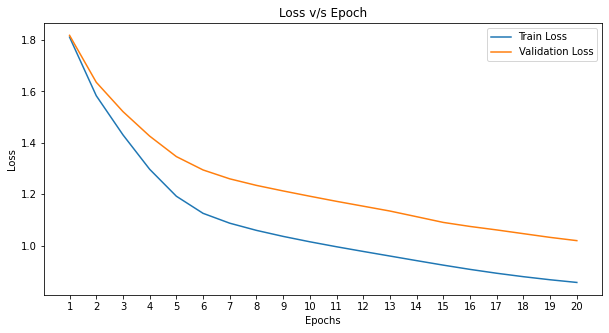

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL3_1)
plt.plot(epochArr,vL3_1)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss", "Validation Loss"])


Model 2

In [ ]:
n_hidden1 = 128
n_hidden2=128

rnn3_2 = RNN3(n_letters, n_hidden1, n_hidden2, n_categories).cuda()
learning_rate = 0.001
optimizer3_2 = torch.optim.SGD(rnn3_2.parameters(),lr= learning_rate)

In [ ]:
trL3_2,vL3_2,preds3_2=evaluate_model2(20,rnn3_2,optimizer3_2)

Epoch 1 Train Loss : 1.8103565033622664
============= Epoch 1 Val Loss : 1.8520517406680908
Epoch 2 Train Loss : 1.5977599813804637
============= Epoch 2 Val Loss : 1.6628486823375928
Epoch 3 Train Loss : 1.4322927967490482
============= Epoch 3 Val Loss : 1.5541968578689562
Epoch 4 Train Loss : 1.3039245492830067
============= Epoch 4 Val Loss : 1.47464862779287
Epoch 5 Train Loss : 1.2158728126389102
============= Epoch 5 Val Loss : 1.4039006141363468
Epoch 6 Train Loss : 1.1482829920063429
============= Epoch 6 Val Loss : 1.3440921859787105
Epoch 7 Train Loss : 1.1043544426921634
============= Epoch 7 Val Loss : 1.299768124920423
Epoch 8 Train Loss : 1.0734790010513695
============= Epoch 8 Val Loss : 1.2624886846633345
Epoch 9 Train Loss : 1.048283827399714
============= Epoch 9 Val Loss : 1.2327336804798228
Epoch 10 Train Loss : 1.026081551296008
============= Epoch 10 Val Loss : 1.2076013305397855
Epoch 11 Train Loss : 1.0057839244088274
============= Epoch 11 Val Loss : 1.184819

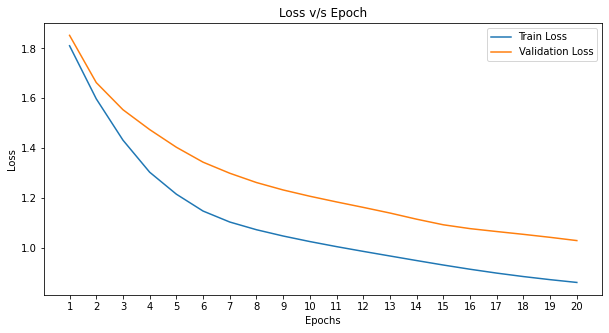

In [ ]:
plt.figure(figsize=(10,5))
epochArr=[i for i in range(1,21)]
plt.plot(epochArr,trL3_2)
plt.plot(epochArr,vL3_2)
plt.xticks(epochArr)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss v/s Epoch")
plt.legend(["Train Loss", "Validation Loss"])

Out of all, we found that model 1 is best. So we will test for it.

Confusion matrix

In [ ]:
print(y_val)
print(preds3_1)

2990      English
15565     Russian
12404     Russian
10722     Russian
16433     Russian
           ...   
3669      English
7947      Russian
18803    Japanese
1428      English
51          Greek
Name: class, Length: 2008, dtype: object
['German', 'Russian', 'Russian', 'German', 'Russian', 'Arabic', 'Czech', 'Italian', 'Czech', 'Japanese', 'Japanese', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'English', 'Russian', 'Arabic', 'Arabic', 'Russian', 'Russian', 'Russian', 'Russian', 'Arabic', 'German', 'Russian', 'Czech', 'Russian', 'Russian', 'Arabic', 'Russian', 'Greek', 'Russian', 'Italian', 'Arabic', 'Russian', 'Russian', 'German', 'Italian', 'Russian', 'Russian', 'German', 'German', 'German', 'English', 'Italian', 'Russian', 'Arabic', 'Italian', 'Italian', 'Japanese', 'Russian', 'German', 'Czech', 'Arabic', 'Russian', 'English', 'Chinese', 'Russian', 'Greek', 'Russian', 'German', 'English', 'Russian', 'Arabic', 'Italian', 'Arabic', 'Russian', 'Arabic', 'Russian', 'Arabic'

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm=confusion_matrix(y_val,preds3_1)
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,182,0,0,0,0,0,8,6,0,1,0,0,0,0,3,0,0,0
1,0,15,0,0,2,0,7,0,0,1,0,1,0,0,1,0,0,0
2,2,0,24,0,2,0,9,0,0,2,2,0,0,0,11,0,0,0
3,0,1,4,0,3,0,14,1,1,1,0,0,0,0,5,0,0,0
4,18,1,21,0,150,0,117,11,0,12,1,0,0,0,36,0,0,0
5,3,0,0,0,2,0,15,2,0,2,1,1,0,0,2,0,0,0
6,4,0,3,0,5,0,56,0,0,1,0,0,0,0,3,0,0,0
7,1,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0
8,2,0,2,0,7,0,9,0,0,0,1,0,0,0,2,0,0,0
9,2,0,1,0,1,0,2,0,0,61,2,0,0,0,2,0,0,0


In [ ]:
def test_model(model):
  Preds=[]
  for iter in range(len(X_test)):
    category=y_test.iloc[iter]
    line=X_test.iloc[iter]
    category_tensor=categoryToTensor(category)
    line_tensor=lineToTensor(line)

    output,_=eval2(category_tensor,line_tensor,model)
    p,p_index=categoryFromOutput(output)
    Preds.append(p)
  acc=(y_test==Preds).sum()/len(X_test)
  print("Test Accuracy : ",acc*100)


In [ ]:
test_model(rnn3_1)

Test Accuracy :  70.0199203187251


# Predictions of given words

In [ ]:
new_names=["Emilia","Alexandra","Sachiko","Vlamidir","Minh","Xi","Muammar","Mukesh","Andrew","Ronaldo"]

In [ ]:
def predict(line_tensor,model):
    hidden = model.initHidden()
    hidden = hidden.cuda()
    line_tensor =line_tensor.cuda()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output


def preds_of_newNames(model,n_predictions):
  for i in new_names:
    print("\n > ",i)
    with torch.no_grad():
      output = predict(lineToTensor(i),model)
      topv, topi = output.topk(n_predictions, 1, True)
      predictions=[]
      for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

Predictions Given by best model of architecture 1

In [ ]:
preds_of_newNames(rnn4,3)


 >  Emilia
(-0.54) Russian
(-2.07) Czech
(-2.27) Italian

 >  Alexandra
(-0.46) Italian
(-2.24) Spanish
(-2.35) Russian

 >  Sachiko
(-0.35) Japanese
(-1.39) Russian
(-4.24) Polish

 >  Vlamidir
(-0.07) Russian
(-3.54) French
(-4.39) English

 >  Minh
(-1.38) Russian
(-1.57) English
(-1.65) Chinese

 >  Xi
(-0.61) Korean
(-1.22) Chinese
(-2.30) Vietnamese

 >  Muammar
(-0.23) Arabic
(-2.71) Russian
(-3.19) English

 >  Mukesh
(-0.78) Russian
(-1.55) German
(-2.53) Dutch

 >  Andrew
(-0.19) English
(-2.91) Spanish
(-3.39) German

 >  Ronaldo
(-0.43) Italian
(-1.98) Russian
(-2.12) Spanish


Predictions Given by best model of architecture 2

In [ ]:
preds_of_newNames(rnn2_3,3)


 >  Emilia
(-0.82) Japanese
(-1.73) Russian
(-2.27) Czech

 >  Alexandra
(-1.37) Italian
(-1.74) Japanese
(-1.81) Russian

 >  Sachiko
(-0.53) Japanese
(-1.31) Russian
(-2.85) Italian

 >  Vlamidir
(-0.01) Russian
(-4.84) Czech
(-6.19) Polish

 >  Minh
(-0.76) English
(-1.77) German
(-2.62) Czech

 >  Xi
(-1.63) Chinese
(-1.91) Arabic
(-2.44) Korean

 >  Muammar
(-0.03) Arabic
(-4.62) English
(-4.79) Chinese

 >  Mukesh
(-0.73) Russian
(-1.61) Czech
(-2.61) German

 >  Andrew
(-0.32) English
(-2.71) German
(-3.30) French

 >  Ronaldo
(-0.33) Italian
(-2.20) Russian
(-3.00) Czech


In [ ]:
def predict2(line_tensor,model):
  hidden1 = model.initHidden1()
  hidden1 = hidden1.cuda()

  hidden2 = model.initHidden2()
  hidden2 = hidden2.cuda()

  line_tensor =line_tensor.cuda()
  for i in range(line_tensor.size()[0]):
      output, hidden1,hidden2 = model(line_tensor[i], hidden1,hidden2)
   
  return output

def preds_of_newNames2(model,n_predictions):

  for i in new_names:
    print("\n >",i)
    with torch.no_grad():
      output = predict2(lineToTensor(i),model)
      topv, topi = output.topk(n_predictions, 1, True)
      predictions=[]
      for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])



Predictions given by best model of Stacked RNN architecture

In [ ]:
preds_of_newNames2(rnn3_1,3)


 > Emilia
(-1.02) Czech
(-1.50) Russian
(-1.64) Italian

 > Alexandra
(-0.42) Italian
(-1.98) Czech
(-2.67) Russian

 > Sachiko
(-0.93) Japanese
(-1.56) Czech
(-1.60) Russian

 > Vladimir
(-0.17) Russian
(-3.06) Czech
(-3.57) Greek

 > Minh
(-0.99) German
(-1.63) Chinese
(-1.93) Russian

 > Xi
(-1.06) Korean
(-1.66) Italian
(-2.18) Vietnamese

 > Muammar
(-0.11) Arabic
(-3.16) German
(-3.88) Czech

 > Mukesh
(-0.92) German
(-0.99) Russian
(-2.86) Irish

 > Andrew
(-1.01) English
(-1.08) German
(-2.28) Czech

 > Ronaldo
(-0.06) Italian
(-3.86) Spanish
(-4.49) Czech
